# SIGNATE Cup
- **目的**： 旅行会社の保有する顧客データ（属性や志向、営業担当との接触履歴等）を元に、旅行パッケージの成約率を予測する
- **評価指標**：AUC
- **目的変数**：予測確率
- 備考： データに意図的にノイズや表記揺れを付与

# メモ
- 別ファイルに記載
- **LightGBMに利用する特徴量の数を減らす**

# ログ
- **df_train**：加工した訓練データ
- **df_train_original**：無加工の訓練データ

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./Colab Notebooks/SIGNATE/SIGNATE CUP_2408/"

df_train = pd.read_csv(INPUT_DIR + "train.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submit.csv", header=None)

In [ ]:
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56歳,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48歳,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


In [ ]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()

In [ ]:
df_train_original["ProdTaken"].value_counts()

,count
ProdTaken,
0,2992
1,497


In [ ]:
# 訓練データ
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [ ]:
# テストデータ
df_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3396 non-null   object 
 2   TypeofContact           3477 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3358 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3465 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3447 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [ ]:
# 訓練データ
df_train_original.isnull().sum()

,0
id,0
Age,100
TypeofContact,6
CityTier,0
DurationOfPitch,121
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,33
ProductPitched,0


In [ ]:
# テストデータ
df_test_original.isnull().sum()

,0
id,0
Age,93
TypeofContact,12
CityTier,0
DurationOfPitch,131
Occupation,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,24
ProductPitched,0


# 前処理

## **Age**

In [ ]:
def get_unique_elements_in_column(df, column):
    unique_elements = df[column].unique()
    return unique_elements

column = "Age"
unique_age_data = get_unique_elements_in_column(df_train, column)
print(unique_age_data)

['50歳' '56歳' nan '三十七歳' '48歳' '19歳' '47歳' '49歳' '33歳' '３１歳' '51歳' '46歳'
 '４９歳' '53才' '20歳' '25歳' '五十三歳' '20代' '44歳' '30歳' '34歳' '29歳' '30代' '41歳'
 '50代' '52歳' '22歳' '３６歳' '28歳' '25才' '五十一歳' '48才' '38才' '三十三歳' '42際' '５０代'
 '35才' '59歳' '四十三歳' '32歳' '４２才' '53歳' '58歳' '40代' '二十六歳' '52際' '54歳' '59才'
 '29才' '21才' '57歳' '37歳' '35歳' '36才' '38歳' '３７歳' '50才' '51才' '43歳' '四十歳'
 '26歳' '31歳' '27歳' '40歳' '３４歳' '40際' '21歳' '24才' '45歳' '36歳' '41才' '38際'
 '18歳' '39歳' '４６歳' '４０代' '５５歳' '58際' '24歳' '41際' '三十一歳' '52才' '３０代' '28才'
 '55際' '60代' '27際' '３２歳' '60歳' '五十四歳' '29際' '三十四歳' '４７歳' '37際' '二十四歳'
 '四十七歳' '58才' '39才' '23才' '３３歳' '４２歳' '４５歳' '３９歳' '５４歳' '55歳' '42歳' '３８歳'
 '47才' '５１歳' '３９才' '51際' '二十七歳' '30才' '２６歳' '４０歳' '36際' '三十歳' '23歳' '二十二歳'
 '37才' '３０歳' '２８歳' '34才' '五十歳' '四十一歳' '５９歳' '３５歳' '２２歳' '３７才' '四十九歳' '42才'
 '４４歳' '２５歳' '44際' '33才' '28際' '２４才' '55才' '４８歳' '四十四歳' '31才' '２０代' '二十歳'
 '22際' '31際' '二十三歳' '39際' '59際' '３３才' '三十六歳' '10代' '２７歳' '49才' '４３歳' '32際'
 '４１歳' '33際' '二十五歳' '27才' '46際' '二十九歳' '3

In [ ]:
import re

def extract_age(text):
    if pd.isna(text):
        return text  # 欠損値がある場合、そのまま返す

    # 年齢を表すテキストから数値を抽出する正規表現パターン
    pattern = r'\d+'

    # 漢数字と対応するアラビア数字の辞書
    kanji_to_arabic = {
        '一': 1, '二': 2, '三': 3, '四': 4, '五': 5,
        '六': 6, '七': 7, '八': 8, '九': 9, '十': 10
    }

    text_string = str(text)

    # テキストから数値を抽出
    match = re.search(pattern, text_string)
    if match:
        # 数値がアラビア数字である場合
        return int(match.group())
    else:
        # 数値が漢数字である場合
        numeric_age = 0
        multiplier = 1  # 「十」の乗数（10の位）
        chars = list(text_string)  # テキストを1文字ずつリストに変換
        i = len(chars) - 1  # テキストを後ろから処理

        while i >= 0:
            char = chars[i]
            if char in kanji_to_arabic:
                if char == '十':
                    # 「十」の処理
                    if multiplier == 1:
                        multiplier = 10
                    else:
                        numeric_age += multiplier
                        multiplier = 10
                else:
                    # 「十」以外の漢数字の場合
                    numeric_age += kanji_to_arabic[char] * multiplier
                    multiplier = 1
            i -= 1

        # 「十」が最後に来た場合の処理
        if multiplier == 10:
            numeric_age += 10

        return numeric_age


# 数値データに変換した年齢を格納するリスト
numeric_age_data = []

# 各要素を数値データに変換
for age_text in unique_age_data:
    if age_text:
        numeric_age = extract_age(age_text)
        numeric_age_data.append(numeric_age)
    else:
        numeric_age_data.append(None)

combined_age_data = list(zip(unique_age_data, numeric_age_data))
compared_age_data = sorted(combined_age_data, key=lambda x: x[1])
df_compared_age = pd.DataFrame(compared_age_data, columns=["text", "numeric"])
# 比較結果↓
# https://docs.google.com/spreadsheets/d/1HML1UZ0cwWt4lix8EliaazquNTDPFurJSxKAi8zrGlA/edit?gid=0#gid=0

In [ ]:
# 本番データセットでも変換処理を行う
df_train["Age"] = df_train["Age"].apply(extract_age)
df_test["Age"] = df_test["Age"].apply(extract_age)
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50.0,Self Enquiry,2,900秒,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56.0,Company Invited,1,14分,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,37.0,Self Enquiry,2,1080秒,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48.0,Company Invited,3,1020秒,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


## **CityTier**

In [ ]:
print(df_train["CityTier"].unique())

[2 1 3]


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   float64
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

## **DurationOfPitch（担当者の売り込み時間）**

In [ ]:
print(df_train["DurationOfPitch"].unique())

['900秒' '14分' '10分' '1080秒' '1020秒' '16分' '840秒' '22分' '20分' '11分' '32分'
 '17分' '24分' '1380秒' '35分' '420秒' '5分' '480秒' '8分' '15分' '960秒' nan '540秒'
 '26分' '13分' '12分' '21分' '25分' '720秒' '9分' '7分' '780秒' '6分' '18分' '31分'
 '600秒' '23分' '28分' '2160秒' '660秒' '1500秒' '1920秒' '27分' '33分' '360秒'
 '1320秒' '1740秒' '1680秒' '29分' '1620秒' '1440秒' '1800秒' '30分' '34分' '4分'
 '19分' '1860秒' '1260秒' '2100秒' '300秒' '2040秒' '1200秒' '1560秒' '1980秒'
 '36分' '1140秒']


In [ ]:
print(df_test["DurationOfPitch"].unique())

['13分' '12分' '540秒' '420秒' '7分' nan '8分' '16分' '22分' '24分' '17分' '11分'
 '23分' '10分' '15分' '960秒' '9分' '18分' '900秒' '840秒' '660秒' '19分' '14分'
 '1020秒' '31分' '1080秒' '300秒' '720秒' '33分' '480秒' '6分' '28分' '1980秒' '27分'
 '600秒' '360秒' '20分' '26分' '21分' '780秒' '1740秒' '34分' '1320秒' '1560秒'
 '32分' '1800秒' '1920秒' '29分' '1380秒' '35分' '1260秒' '30分' '1860秒' '2040秒'
 '25分' '240秒' '1620秒' '5分' '1200秒' '1500秒' '36分' '1440秒' '2100秒' '1680秒'
 '1140秒' '2160秒']


In [ ]:
# データ
unique_pitch = df_train["DurationOfPitch"].unique()

# テキストデータから数字の部分だけを抽出して数値データに変換
numeric_pitch = []
for item in unique_pitch:
    if pd.notna(item):
        if '秒' in item:
            seconds = int(item.replace('秒', ''))
            minutes = int(seconds / 60)
            numeric_pitch.append(minutes)
        elif '分' in item:
            minutes = int(item.replace('分', ''))
            numeric_pitch.append(minutes)
    else:
        numeric_pitch.append(pd.NA)

# 結果を出力
compared_pitch_data = list(zip(unique_pitch, numeric_pitch))
df_compared_pitch = pd.DataFrame(compared_pitch_data, columns=["text", "numeric"])
df_compared_pitch.head()

,text,numeric
0,900秒,15
1,14分,14
2,10分,10
3,1080秒,18
4,1020秒,17


In [ ]:
# 関数として定義
def convert_to_numeric_pitch(item):
    if pd.notna(item):
        if '秒' in item:
            seconds = int(item.replace('秒', ''))
            minutes = int(seconds / 60)
            return minutes
        elif '分' in item:
            minutes = int(item.replace('分', ''))
            return minutes

# 本番データセットでも変換処理を行う
df_train["DurationOfPitch"] = df_train["DurationOfPitch"].apply(convert_to_numeric_pitch)
df_test["DurationOfPitch"] = df_test["DurationOfPitch"].apply(convert_to_numeric_pitch)
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50.0,Self Enquiry,2,15.0,Large Business,male,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56.0,Company Invited,1,14.0,Salaried,Male,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10.0,Large Business,Female,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,37.0,Self Enquiry,2,18.0,Small Business,female,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48.0,Company Invited,3,17.0,Small Business,female,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


## **Gender**  
※男性：１ / 女性：０となるように変換

In [ ]:
print(df_train["Gender"].unique())

['male' 'Male' 'Female' 'female' 'ｆｅｍａｌｅ' 'FEMALE' 'Ｍａｌｅ' 'Fe Male' 'MALE'
 'ｆｅ\u3000ｍａｌｅ' 'fe male' 'Ｆｅｍａｌｅ' 'ｍａｌｅ' 'FE MALE' 'Ｆｅ\u3000Ｍａｌｅ'
 'ＦＥＭＡＬＥ' 'ＦＥ\u3000ＭＡＬＥ' 'ＭＡＬＥ']


In [ ]:
import unicodedata

def normalize_gender(gender):
    # 全角を半角に変換し、小文字に変換する
    normalized = unicodedata.normalize('NFKC', gender).lower().strip()

    # "female" と "fe male" を 0、"male" を 1 に統一
    if "male" in normalized.replace(" ", ""):
        if "fe" in normalized.replace(" ", ""):
            return 0
        else:
            return 1
    return None  # それ以外の場合は None などの適切な値を返す

gender_data = df_train["Gender"].unique()

# 正規化したデータを格納するリスト
normalized_gender_data = []

for gender in gender_data:
    normalized_gender = normalize_gender(gender)
    normalized_gender_data.append(normalized_gender)

compared_gender_data = list(zip(normalized_gender_data, gender_data))
df_compared_gender = pd.DataFrame(compared_gender_data, columns=["text", "numeric"])
df_compared_gender

,text,numeric
0,1,male
1,1,Male
2,0,Female
3,0,female
4,0,ｆｅｍａｌｅ
5,0,FEMALE
6,1,Ｍａｌｅ
7,0,Fe Male
8,1,MALE
9,0,ｆｅ ｍａｌｅ


In [ ]:
# 本番データセットでも変換処理を行う
df_train["Gender"] = df_train["Gender"].apply(normalize_gender)
df_test["Gender"] = df_test["Gender"].apply(normalize_gender)
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,50.0,Self Enquiry,2,15.0,Large Business,1,1.0,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1
1,1,56.0,Company Invited,1,14.0,Salaried,1,1.0,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0
2,2,NaN,Self Enquiry,1,10.0,Large Business,0,1.0,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1
3,3,37.0,Self Enquiry,2,18.0,Small Business,0,1.0,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0
4,4,48.0,Company Invited,3,17.0,Small Business,0,1.0,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1


## **Designation（顧客の指定？？）**

In [ ]:
print(df_train["Designation"].unique())

['Executive' 'Senior Manager' 'AVP' 'Manager' 'Senior Manage𝙧' 'Execuｔive'
 'Μanager' 'VP' 'Sеnior Manager' 'ΑVP' 'АVP' 'E×ecutive' 'Mαnage𝙧'
 'Executiѵе' 'Ѕenior Manager' 'Managеr' 'Еxecutivе' 'Senior Μanαger'
 'Еxecuｔive' 'Exеcutivе' 'Exеcutive' 'Senior Managе𝙧' 'Manage𝙧'
 'Senio𝙧 Manager' 'Manαger' 'Μanage𝙧' 'Manαgеr' 'Senior Managеr'
 'Executivе' 'Executiѵe' 'Е×еcutive' 'Еxecutive' 'VＰ' 'Տenior Μanager'
 'Exеcutiѵе' 'Senior Manαger' 'Mαnager' 'Senior Mαnαger' 'E×еcutiѵe'
 'Ѕenior Manαger' 'Exеcｕtive' 'Execｕtive' 'Mαnαger' 'Μanagеr' 'E×ecｕtive'
 'Sеnior Managеr' 'Տenior Manager' 'AVＰ' 'Exеcｕtivе' 'Mαnagеr' 'Еxеcutivе'
 'Senior Mαnager' 'Е×ecutive']


In [ ]:
# 表記揺れがあるデータについて、その中に含まれる１つの文字をベースにグルーピング
def convert_by_rules(data):
    converted_designation_data = []
    for item in data:
        # 規則に基づいて変換
        if 'c' in item.lower():
            converted_designation_data.append('Executive')
        elif 'v' in item.lower():
            if len(item) == 2:
              converted_designation_data.append('VP')
            else:
              converted_designation_data.append('AVP')
        elif 'o' in item.lower():
            converted_designation_data.append('Senior Manager')
        else:
            converted_designation_data.append('Manager')
    return converted_designation_data

designation_data = df_train["Designation"].unique()
converted_designation_data = convert_by_rules(designation_data)
compared_designation_data = list(zip(converted_designation_data, designation_data))
df_compared_designation = pd.DataFrame(compared_designation_data, columns=["after", "before"])
df_compared_designation # 変換前と変換後を比較

,after,before
0,Executive,Executive
1,Senior Manager,Senior Manager
2,AVP,AVP
3,Manager,Manager
4,Senior Manager,Senior Manage𝙧
5,Executive,Execuｔive
6,Manager,Μanager
7,VP,VP
8,Senior Manager,Sеnior Manager
9,AVP,ΑVP


In [ ]:
# 本番データに適用
df_train['Converted Designation'] = convert_by_rules(df_train['Designation'])
df_train.drop(columns=['Designation'], inplace=True)
df_test['Converted Designation'] = convert_by_rules(df_test['Designation'])
df_test.drop(columns=['Designation'], inplace=True)
df_train.head()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,customer_info,ProdTaken,Converted Designation
0,0,50.0,Self Enquiry,2,15.0,Large Business,1,1.0,4.0,Basic,3.0,5,1,4,253905.0,未婚 車未所持 子供なし,1,Executive
1,1,56.0,Company Invited,1,14.0,Salaried,1,1.0,4.0,Standard,3.0,2,1,4,404475.0,"離婚済み,車あり,子供無し",0,Senior Manager
2,2,NaN,Self Enquiry,1,10.0,Large Business,0,1.0,3.0,Basic,3.0,4,0,4,278145.0,"結婚済み、自動車未所有,子供なし",1,Executive
3,3,37.0,Self Enquiry,2,18.0,Small Business,0,1.0,3.0,Standard,4.0,1,0,5,326805.0,離婚済み、車所持、子供無し,0,Senior Manager
4,4,48.0,Company Invited,3,17.0,Small Business,0,1.0,3.0,Basic,4.0,4,0,4,258435.0,独身／車所持／無子,1,Executive


In [ ]:
# "Designation"についてダミー変数化
df_train_dummies_01 = pd.get_dummies(df_train, columns=['Converted Designation'], drop_first = True, dtype=int)
df_test_dummies_01 = pd.get_dummies(df_test, columns=['Converted Designation'], drop_first = True, dtype=int)

In [ ]:
df_train_dummies_01

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,customer_info,ProdTaken,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP
0,0,50.0,Self Enquiry,2,15.0,Large Business,1,1.0,4.0,Basic,...,5,1,4,253905.0,未婚 車未所持 子供なし,1,1,0,0,0
1,1,56.0,Company Invited,1,14.0,Salaried,1,1.0,4.0,Standard,...,2,1,4,404475.0,"離婚済み,車あり,子供無し",0,0,0,1,0
2,2,NaN,Self Enquiry,1,10.0,Large Business,0,1.0,3.0,Basic,...,4,0,4,278145.0,"結婚済み、自動車未所有,子供なし",1,1,0,0,0
3,3,37.0,Self Enquiry,2,18.0,Small Business,0,1.0,3.0,Standard,...,1,0,5,326805.0,離婚済み、車所持、子供無し,0,0,0,1,0
4,4,48.0,Company Invited,3,17.0,Small Business,0,1.0,3.0,Basic,...,4,0,4,258435.0,独身／車所持／無子,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,3484,40.0,Self Enquiry,2,26.0,Salaried,1,2.0,3.0,Basic,...,3,0,1,258900.0,離婚済み 乗用車所持 子供なし,1,1,0,0,0
3485,3485,40.0,Self Enquiry,1,9.0,Large Business,1,3.0,3.0,Basic,...,5,0,3,260415.0,結婚済み、車所持、子供2人,0,1,0,0,0
3486,3486,31.0,Self Enquiry,1,14.0,Small Business,0,3.0,2.0,Standard,...,5,0,4,317340.0,独身／車所持／こども1人,0,0,0,1,0
3487,3487,56.0,Company Invited,2,15.0,Salaried,1,3.0,6.0,King,...,7,1,4,527910.0,結婚済み、自動車未所有、子供2人,1,0,0,0,1


## **TypeofContact（顧客の連絡方法）**

In [ ]:
print(df_train_dummies_01["TypeofContact"].unique())

['Self Enquiry' 'Company Invited' nan]


In [ ]:
print(df_train_dummies_01["TypeofContact"].value_counts())

TypeofContact
Self Enquiry       2194
Company Invited    1289
Name: count, dtype: int64


欠損値の件数は6件なので、数の多い"Self Enquiry"で埋めてしまう

In [ ]:
# 欠損値の補完
df_train_dummies_01['TypeofContact'].fillna('Self Enquiry', inplace=True)
df_test_dummies_01['TypeofContact'].fillna('Self Enquiry', inplace=True)
df_train_dummies_01["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,2200
Company Invited,1289


In [ ]:
df_test_dummies_01["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,2262
Company Invited,1227


In [ ]:
df_test_original["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,2250
Company Invited,1227


In [ ]:
# "TypeofContact"についてダミー変数化
df_train = pd.get_dummies(df_train_dummies_01, columns=["TypeofContact"], drop_first = True, dtype=int)
df_test = pd.get_dummies(df_test_dummies_01, columns=["TypeofContact"], drop_first = True, dtype=int)

## **MonthlyIncome（月収）**

In [ ]:
df_test["MonthlyIncome"].unique()

array(['496950.0', '月収30.0万円', '月収26.0万円', ..., '349770.0', '272430.0',
       '411795.0'], dtype=object)

In [ ]:
# 文字列の処理関数を定義
def convert_to_yen(value):
    # 値が文字列かどうかを確認
    if isinstance(value, str):
        # 数値データはそのままfloat型に変換
        if value.replace('.', '', 1).isdigit():
            return float(value)

        # 「月収XX万円」の形式の場合、XXを取り出して10000を掛ける
        elif '月収' in value and '万円' in value:
            value = value.replace('月収', '').replace('万円', '')
            return float(value) * 10000

    # すでに float 型の値はそのまま返す
    elif isinstance(value, (float, int)):
        return value

    # その他の形式がある場合には NaN を返す
    return pd.NA

# "MonthlyIncome" カラムを数値データに変換
df_train['MonthlyIncome'] = df_train['MonthlyIncome'].apply(convert_to_yen)


In [ ]:
df_train["MonthlyIncome"].unique()

array([253905., 404475., 278145., ..., 317340., 527910., 278190.])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    3489 non-null   int64  
 1   Age                                   3389 non-null   float64
 2   CityTier                              3489 non-null   int64  
 3   DurationOfPitch                       3368 non-null   float64
 4   Occupation                            3489 non-null   object 
 5   Gender                                3489 non-null   int64  
 6   NumberOfPersonVisiting                3489 non-null   float64
 7   NumberOfFollowups                     3456 non-null   float64
 8   ProductPitched                        3489 non-null   object 
 9   PreferredPropertyStar                 3489 non-null   float64
 10  NumberOfTrips                         3467 non-null   object 
 11  Passport         

In [ ]:
df_test['MonthlyIncome'] = df_test['MonthlyIncome'].apply(convert_to_yen)

In [ ]:
df_test["MonthlyIncome"].unique()

array([496950., 300000., 260000., ..., 349770., 272430., 411795.])

## **Occupation**

In [ ]:
df_train["Occupation"].unique()

array(['Large Business', 'Salaried', 'Small Business'], dtype=object)

In [ ]:
df_test["Occupation"].unique()

array(['Small Business', 'Salaried', 'Large Business'], dtype=object)

In [ ]:
# ダミー変数化
df_train = pd.get_dummies(df_train, columns=["Occupation"], drop_first = True, dtype=int)
df_test = pd.get_dummies(df_test, columns=["Occupation"], drop_first = True, dtype=int)
df_train.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,MonthlyIncome,customer_info,ProdTaken,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business
0,0,50.0,2,15.0,1,1.0,4.0,Basic,3.0,5,...,253905.0,未婚 車未所持 子供なし,1,1,0,0,0,1,0,0
1,1,56.0,1,14.0,1,1.0,4.0,Standard,3.0,2,...,404475.0,"離婚済み,車あり,子供無し",0,0,0,1,0,0,1,0
2,2,NaN,1,10.0,0,1.0,3.0,Basic,3.0,4,...,278145.0,"結婚済み、自動車未所有,子供なし",1,1,0,0,0,1,0,0
3,3,37.0,2,18.0,0,1.0,3.0,Standard,4.0,1,...,326805.0,離婚済み、車所持、子供無し,0,0,0,1,0,1,0,1
4,4,48.0,3,17.0,0,1.0,3.0,Basic,4.0,4,...,258435.0,独身／車所持／無子,1,1,0,0,0,0,0,1


In [ ]:
df_test.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,PitchSatisfactionScore,MonthlyIncome,customer_info,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business
0,3489,48.0,2,13.0,1,1.0,4.0,Super De|uxe,3.0,7,...,3,496950.0,結婚済み 車所持 子供なし,0,0,0,0,1,0,1
1,3490,30.0,2,12.0,0,1.0,4.0,Standard,3.0,4,...,3,300000.0,結婚済み、車未所持、子供なし,0,0,1,0,1,0,1
2,3491,25.0,1,9.0,0,1.0,4.0,Basic,3.0,1,...,3,260000.0,離婚済み、自動車未所有、子供なし,1,0,0,0,1,1,0
3,3492,21.0,2,7.0,1,1.0,4.0,Basic,4.0,1,...,3,259875.0,離婚済み、自動車所有、子供なし,0,0,1,0,0,1,0
4,3493,41.0,1,7.0,1,1.0,4.0,Basic,3.0,1,...,4,268830.0,独身/車所持／子供なし,1,0,0,0,0,1,0


## **NumberOfPersonVisiting**

In [ ]:
df_train["NumberOfPersonVisiting"].unique()

array([1., 2., 3., 4.])

In [ ]:
df_test["NumberOfPersonVisiting"].unique()

array([1., 2., 3., 4.])

## **NumberOfFollowups**

In [ ]:
df_train["NumberOfFollowups"].unique()

array([  4.,   3.,   5.,   1.,   2., 100.,  nan, 500., 400.,   6., 300.,
       600.])

In [ ]:
df_test["NumberOfFollowups"].unique()

array([  4.,   3., 300.,   5., 400.,   1.,   2.,   6., 100.,  nan, 500.,
       200.])

In [ ]:
df_train["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,1396
3.0,1279
5.0,519
2.0,108
1.0,77
6.0,38
300.0,17
400.0,15
500.0,5


## **ProductPitched**

In [ ]:
df_train["ProductPitched"].unique()

array(['Basic', 'Standard', 'Super Deluxe', 'basic', 'SUPER DELUXE',
       'super deluxe', 'BASIC', 'Deluxe', 'deluxe', 'STANᗞARD',
       'STANDARD', 'Вasic', 'DELUXE', 'ꓢuper De|uxe', 'Ѕuper Deluxe',
       'BAՏIC', 'Basıc', 'King', 'Super De|uxe', 'king', 'standard',
       'KING', 'BΑSIC', 'B𝖺sic', 'De|uxe', 'ᎠELUXE', 'Basiϲ', 'de|u×e',
       'Delu×e', 'Standar𝔡', 'Basi𝘤', 'Βasic', 'Տuper Deluxe', 'Staոdard',
       'BAꓢIC', 'ᗞeluxe', 'Տtandard', 'Βası𝘤', 'Kıng', 'Baｓic', 'basıc',
       'super de|uxe', 'Stand𝖺rd', 'S𝘵andard', '𐊡asic', 'St𝖺ndard',
       'Super ᗞeluxe', 'de|uxe', 'ｓuper deluxe', 'STANDARᎠ', 'Basiс',
       'DΕLUXΕ', 'ꓢuper Deluxe', 'BASΙC', 'ꓢtandard', 'В𝖺sic', 'Standa𝘳d',
       'basiϲ', 'staոdard', 'Super Ꭰeluxe', 'DELUXΕ', 'Ѕtandard', '𐊡asi𝘤',
       'Ꭰeluxe', 'Kıոg', '𝙳eluxe', 'Kiոg', 'Βasıc', 'BASIС',
       'SUPER DΕLUXE', 'B𝖺si𝘤', 'ΒASIС', 'Super 𝙳eluxe', 'Տtanda𝘳d',
       'Basıϲ', 'ЅTANDARD'], dtype=object)

In [ ]:
df_test["ProductPitched"].unique()

array(['Super De|uxe', 'Standard', 'Basic', 'Deluxe', 'Super Deluxe',
       'DELUXE', 'King', 'standard', 'basic', 'BASIC', 'basıc',
       'STANDARD', 'SUPER DELUXE', 'Ѕtandard', 'super deluxe', '𐊡asic',
       'SUPER ᎠELUXE', 'SUPER ᗞELUXE', 'Βasic', 'king', 'Basiс',
       'ꓢtandard', 'Super 𝙳eluxe', 'ᗞeluxe', 'Basi𝘤', 'Staոdard',
       'deluxe', 'DELUXΕ', 'De|uxe', 'Basıc', 'Delu×e', 'basiϲ', 'Baｓic',
       'Вasic', 'Stand𝖺rd', 'KING', 'B𝖺si𝘤', 'basiс', '𝙳eluxe', 'Ꭰeluxe',
       'BASIС', 'Super ᗞeluxe', 'STANDARᎠ', 'Stan𝔡ard', 'STΑNDARD',
       'ᗞELUXE', 'Baｓıc', 'de|uxe', 'Super Ꭰeluxe', 'Super Delu×e',
       'Basıϲ', 'ꓢuper Deluxe', 'SUPΕR ᎠELUXE', 'Ꭰe|uxe', 'B𝖺sic',
       'Basiϲ', 'stan𝔡ard', 'BASΙC', 'basi𝘤', 'stand𝖺rd', 'St𝖺ndard',
       'Kıng', 'baｓic', 'Bası𝘤', 'BASΙС', 'S𝘵𝖺nda𝘳d', 'kiոg', 'Standa𝘳d',
       'standar𝔡', 'Stand𝖺𝘳d', 'BAЅIC'], dtype=object)

In [ ]:
# 表記揺れがあるデータについて、その中に含まれる１つの文字をベースにグルーピング
def convert_by_rules(data):
    converted_designation_data = []
    for item in data:
        # 規則に基づいて変換
        if len(item) == 4:
            converted_designation_data.append('King')
        elif len(item) == 5:
            converted_designation_data.append('Basic')
        elif len(item) == 6:
            converted_designation_data.append('Deluxe')
        elif len(item) == 8:
            converted_designation_data.append('Standard')
        else:
            converted_designation_data.append('Super Deluxe')
    return converted_designation_data

pitch_data = df_train["ProductPitched"].unique()
converted_pitch_data = convert_by_rules(pitch_data)
compared_pitch_data = list(zip(pitch_data, converted_pitch_data))
df_compared_pitch = pd.DataFrame(compared_pitch_data, columns=["before", "after"])
df_compared_pitch # 変換前と変換後を比較

,before,after
0,Basic,Basic
1,Standard,Standard
2,Super Deluxe,Super Deluxe
3,basic,Basic
4,SUPER DELUXE,Super Deluxe
...,...,...
71,ΒASIС,Basic
72,Super 𝙳eluxe,Super Deluxe
73,Տtanda𝘳d,Standard
74,Basıϲ,Basic


In [ ]:
# 本番データに適用
df_train['Converted ProductPitched'] = convert_by_rules(df_train['ProductPitched'])
df_train.drop(columns=['ProductPitched'], inplace=True)
df_test['Converted ProductPitched'] = convert_by_rules(df_test['ProductPitched'])
df_test.drop(columns=['ProductPitched'], inplace=True)
df_train.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,customer_info,ProdTaken,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched
0,0,50.0,2,15.0,1,1.0,4.0,3.0,5,1,...,未婚 車未所持 子供なし,1,1,0,0,0,1,0,0,Basic
1,1,56.0,1,14.0,1,1.0,4.0,3.0,2,1,...,"離婚済み,車あり,子供無し",0,0,0,1,0,0,1,0,Standard
2,2,NaN,1,10.0,0,1.0,3.0,3.0,4,0,...,"結婚済み、自動車未所有,子供なし",1,1,0,0,0,1,0,0,Basic
3,3,37.0,2,18.0,0,1.0,3.0,4.0,1,0,...,離婚済み、車所持、子供無し,0,0,0,1,0,1,0,1,Standard
4,4,48.0,3,17.0,0,1.0,3.0,4.0,4,0,...,独身／車所持／無子,1,1,0,0,0,0,0,1,Basic


In [ ]:
# "Designation"についてダミー変数化
df_train = pd.get_dummies(df_train, columns=['Converted ProductPitched'], drop_first = True, dtype=int)
df_test = pd.get_dummies(df_test, columns=['Converted ProductPitched'], drop_first = True, dtype=int)

In [ ]:
df_train.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe
0,0,50.0,2,15.0,1,1.0,4.0,3.0,5,1,...,0,0,0,1,0,0,0,0,0,0
1,1,56.0,1,14.0,1,1.0,4.0,3.0,2,1,...,0,1,0,0,1,0,0,0,1,0
2,2,NaN,1,10.0,0,1.0,3.0,3.0,4,0,...,0,0,0,1,0,0,0,0,0,0
3,3,37.0,2,18.0,0,1.0,3.0,4.0,1,0,...,0,1,0,1,0,1,0,0,1,0
4,4,48.0,3,17.0,0,1.0,3.0,4.0,4,0,...,0,0,0,0,0,1,0,0,0,0


## **PreferredPropertyStar**

In [ ]:
df_train["PreferredPropertyStar"].unique()

array([3., 4., 5.])

In [ ]:
df_test["PreferredPropertyStar"].unique()

array([3., 4., 5.])

## **NumberOfTrips**

In [ ]:
df_train["NumberOfTrips"].unique()

array(['5', '2', '4', '1', '年に1回', '年に2回', '年に6回', '3', '年に5回', '7', '6',
       '半年に1回', '年に4回', '年に3回', '8', '年に8回', nan, '年に7回', '四半期に1回'],
      dtype=object)

In [ ]:
df_test["NumberOfTrips"].unique()

array(['7', '4', '1', '年に6回', '5', '3', '2', '年に4回', '年に1回', '6', '年に2回',
       '年に3回', '年に5回', '年に7回', nan, '半年に1回', '四半期に1回', '年に8回', '8'],
      dtype=object)

In [ ]:
# 文字列の処理関数を定義
def convert(value):
    # 値が文字列かどうかを確認
    if isinstance(value, str):
        # 数値データはそのままfloat型に変換
        if value.replace('.', '', 1).isdigit():
            return float(value)

        # 「半年にXX」の形式の場合、結果を2倍する
        elif '半年に' in value:
            value = value.replace('半年に', '').replace('回', '')
            return float(value)*2

        # 「年にXX」の形式の場合
        elif '年に' in value:
            value = value.replace('年に', '').replace('回', '')
            return float(value)

        # 「四半期にXX」の形式の場合
        elif '四半期に' in value:
            value = value.replace('四半期に', '').replace('回', '')
            return float(value)*4

    # すでに float 型の値はそのまま返す
    elif isinstance(value, (float, int)):
        return value

    # その他の形式がある場合には NaN を返す
    return pd.NA

# カラムを数値データに変換
trip_data = df_train['NumberOfTrips'].unique()
converted_trip_data = [convert(value) for value in trip_data]
compared_trip_data = list(zip(trip_data, converted_trip_data))
df_compared_trip = pd.DataFrame(compared_trip_data, columns=["before", "after"])
df_compared_trip # 変換前と変換後を比較

,before,after
0,5,5.0
1,2,2.0
2,4,4.0
3,1,1.0
4,年に1回,1.0
5,年に2回,2.0
6,年に6回,6.0
7,3,3.0
8,年に5回,5.0
9,7,7.0


In [ ]:
df_train['NumberOfTrips'] = df_train['NumberOfTrips'].apply(convert)
df_test['NumberOfTrips'] = df_test['NumberOfTrips'].apply(convert)
df_train.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe
0,0,50.0,2,15.0,1,1.0,4.0,3.0,5.0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,56.0,1,14.0,1,1.0,4.0,3.0,2.0,1,...,0,1,0,0,1,0,0,0,1,0
2,2,NaN,1,10.0,0,1.0,3.0,3.0,4.0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,37.0,2,18.0,0,1.0,3.0,4.0,1.0,0,...,0,1,0,1,0,1,0,0,1,0
4,4,48.0,3,17.0,0,1.0,3.0,4.0,4.0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_train['NumberOfTrips'].value_counts()

,count
NumberOfTrips,
2.0,1164
3.0,820
5.0,515
1.0,409
7.0,256
4.0,163
6.0,130
8.0,10


## **Passport**

In [ ]:
df_train["Passport"].unique()

array([1, 0])

In [ ]:
df_test["Passport"].unique()

array([0, 1])

## **PitchSatisfactionScore**

In [ ]:
df_train["PitchSatisfactionScore"].unique()

array([4, 5, 3, 2, 1])

In [ ]:
df_test["PitchSatisfactionScore"].unique()

array([3, 4, 5, 2, 1])

## **customer_info**

In [ ]:
print(df_train["customer_info"])

0           未婚 車未所持 子供なし
1          離婚済み,車あり,子供無し
2       結婚済み、自動車未所有,子供なし
3          離婚済み、車所持、子供無し
4              独身／車所持／無子
              ...       
3484     離婚済み 乗用車所持 子供なし
3485       結婚済み、車所持、子供2人
3486        独身／車所持／こども1人
3487    結婚済み、自動車未所有、子供2人
3488      結婚済み,車未所持、子供1人
Name: customer_info, Length: 3489, dtype: object


In [ ]:
# 結婚、車、子供に関する情報を抽出する関数
def extract_info(info):
    marriage_status = None
    car_status = 0
    children_status = 0

    # 結婚情報の抽出
    if re.search(r'未婚|独身', info):
        marriage_status = 'unmarried'
    elif re.search(r'結婚済み', info):
        marriage_status = 'married'
    elif re.search(r'離婚済み', info):
        marriage_status = 'divorced'

    # 車の情報の抽出
    if re.search(r'車未所持|車なし|自動車未所有|車保有なし|自家用車なし', info):
        car_status = 0
    elif re.search(r'車あり|車所持|車保有|自家用車|自動車所有', info):
        car_status = 1

    # 子供情報の抽出
    children_info = re.search(r'(\d+)', info)
    if children_info:
        # 数字が含まれている場合、その数を子供の人数として扱う
        children_status = int(children_info.group())

    return marriage_status, car_status, children_status


# カスタム関数を適用して、各カラムに情報を格納
df_train_sample = df_train.copy()
df_train_sample[['MarriageStatus', 'CarStatus', 'ChildrenStatus']] = df_train['customer_info'].apply(
    lambda x: pd.Series(extract_info(x))
)
df_train_sample.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,TypeofContact_Self Enquiry,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,MarriageStatus,CarStatus,ChildrenStatus
0,0,50.0,2,15.0,1,1.0,4.0,3.0,5.0,1,...,1,0,0,0,0,0,0,unmarried,0,0
1,1,56.0,1,14.0,1,1.0,4.0,3.0,2.0,1,...,0,1,0,0,0,1,0,divorced,1,0
2,2,NaN,1,10.0,0,1.0,3.0,3.0,4.0,0,...,1,0,0,0,0,0,0,married,0,0
3,3,37.0,2,18.0,0,1.0,3.0,4.0,1.0,0,...,1,0,1,0,0,1,0,divorced,1,0
4,4,48.0,3,17.0,0,1.0,3.0,4.0,4.0,0,...,0,0,1,0,0,0,0,unmarried,1,0


In [ ]:
df_train_sample.isnull().sum()

,0
id,0
Age,100
CityTier,0
DurationOfPitch,121
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,33
PreferredPropertyStar,0
NumberOfTrips,22
Passport,0


In [ ]:
df_train_sample["ChildrenStatus"].unique()

array([0, 1, 2, 3])

In [ ]:
df_train_sample["MarriageStatus"].unique()

array(['unmarried', 'divorced', 'married'], dtype=object)

In [ ]:
df_train_sample["CarStatus"].unique()

array([0, 1])

In [ ]:
# CarStatus が null になっている行の customer_info の値を取得
null_car_status_info = df_train_sample[df_train_sample['CarStatus'].isnull()]['customer_info']

# 結果を表示
null_car_status_info

,customer_info


In [ ]:
# # CSV出力
# df_train["customer_info"].to_csv("train_customer_info.csv", index=False, header=None)
# from google.colab import files
# files.download('train_customer_info.csv')

In [ ]:
# それぞれ本番データに適用
df_train[['MarriageStatus', 'CarStatus', 'ChildrenStatus']] = df_train['customer_info'].apply(
    lambda x: pd.Series(extract_info(x))
)
df_train = df_train.drop(columns=['customer_info'])
df_train = pd.get_dummies(df_train, columns=['MarriageStatus'], drop_first = True, dtype=int)

df_test[['MarriageStatus', 'CarStatus', 'ChildrenStatus']] = df_test['customer_info'].apply(
    lambda x: pd.Series(extract_info(x))
)
df_test = df_test.drop(columns=['customer_info'])
df_test = pd.get_dummies(df_test, columns=['MarriageStatus'], drop_first = True, dtype=int)

df_train.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,CarStatus,ChildrenStatus,MarriageStatus_married,MarriageStatus_unmarried
0,0,50.0,2,15.0,1,1.0,4.0,3.0,5.0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,56.0,1,14.0,1,1.0,4.0,3.0,2.0,1,...,1,0,0,0,1,0,1,0,0,0
2,2,NaN,1,10.0,0,1.0,3.0,3.0,4.0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,37.0,2,18.0,0,1.0,3.0,4.0,1.0,0,...,0,1,0,0,1,0,1,0,0,0
4,4,48.0,3,17.0,0,1.0,3.0,4.0,4.0,0,...,0,1,0,0,0,0,1,0,0,1


In [ ]:
df_test.head()

,id,Age,CityTier,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,...,Occupation_Salaried,Occupation_Small Business,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,CarStatus,ChildrenStatus,MarriageStatus_married,MarriageStatus_unmarried
0,3489,48.0,2,13.0,1,1.0,4.0,3.0,7.0,0,...,0,1,0,0,0,1,1,0,1,0
1,3490,30.0,2,12.0,0,1.0,4.0,3.0,4.0,1,...,0,1,0,0,1,0,0,0,1,0
2,3491,25.0,1,9.0,0,1.0,4.0,3.0,1.0,0,...,1,0,0,0,0,0,0,0,0,0
3,3492,21.0,2,7.0,1,1.0,4.0,4.0,1.0,0,...,1,0,0,0,0,0,1,0,0,0
4,3493,41.0,1,7.0,1,1.0,4.0,3.0,1.0,0,...,1,0,0,0,0,0,1,0,0,1


# EDA

<Axes: >

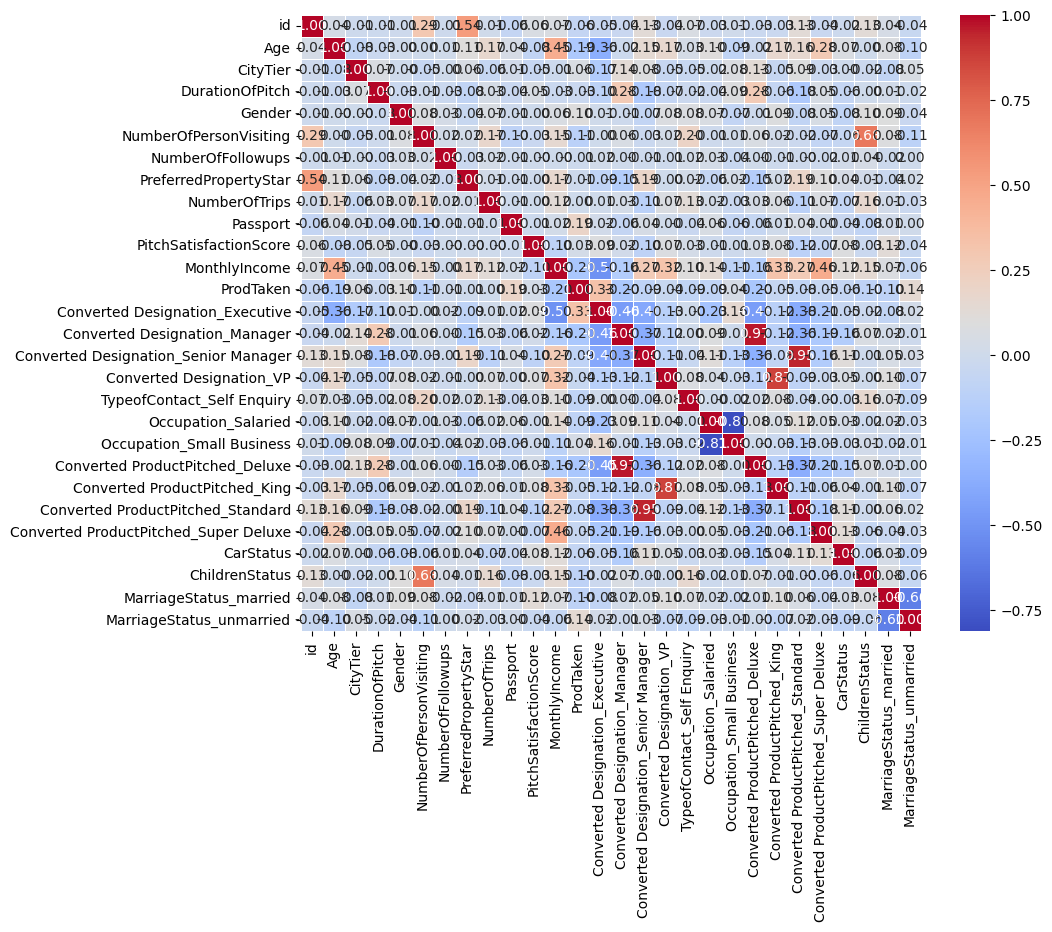

In [ ]:
# とりあえず相関関係を見る

correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

In [ ]:
correlated_pairs = []

# 行列のすべての組み合わせをチェック
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= 0.4:  # 絶対値が0.4以上の組を選択
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            correlated_pairs.append((colname1, colname2, correlation_matrix.iloc[i, j]))

# 結果をデータフレームに変換
correlated_df = pd.DataFrame(correlated_pairs, columns=['Column 1', 'Column 2', 'Correlation'])
correlated_df

,Column 1,Column 2,Correlation
0,PreferredPropertyStar,id,0.535946
1,MonthlyIncome,Age,0.451561
2,Converted Designation_Executive,MonthlyIncome,-0.510171
3,Converted Designation_Manager,Converted Designation_Executive,-0.461636
4,Occupation_Small Business,Occupation_Salaried,-0.810956
5,Converted ProductPitched_Deluxe,Converted Designation_Executive,-0.451846
6,Converted ProductPitched_Deluxe,Converted Designation_Manager,0.967326
7,Converted ProductPitched_King,Converted Designation_VP,0.869250
8,Converted ProductPitched_Standard,Converted Designation_Senior Manager,0.946281
9,Converted ProductPitched_Super Deluxe,MonthlyIncome,0.460714


# 予測

## 決定木  
※turorialと同じコードで実装

In [ ]:
df_train.isnull().sum()

,0
id,0
Age,100
CityTier,0
DurationOfPitch,121
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,33
PreferredPropertyStar,0
NumberOfTrips,22
Passport,0


In [ ]:
# 欠損値を平均で補完
mean_values = df_train.mean()
df_train_filled = df_train.fillna(mean_values)
df_train_filled.isnull().sum()

,0
id,0
Age,0
CityTier,0
DurationOfPitch,0
Gender,0
NumberOfPersonVisiting,0
NumberOfFollowups,0
PreferredPropertyStar,0
NumberOfTrips,0
Passport,0


In [ ]:
y_filled = df_train_filled["ProdTaken"]
X_filled = df_train_filled.drop(columns =['id','ChildrenStatus','NumberOfPersonVisiting','NumberOfFollowups','PreferredPropertyStar','Occupation_Small Business','PitchSatisfactionScore','ProdTaken'], axis = 1)
X_filled.head()

,Age,CityTier,DurationOfPitch,Gender,NumberOfTrips,Passport,MonthlyIncome,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,CarStatus,MarriageStatus_married,MarriageStatus_unmarried
0,50.000000,2,15.0,1,5.0,1,253905.0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,56.000000,1,14.0,1,2.0,1,404475.0,0,0,1,0,0,1,0,0,1,0,1,0,0
2,38.889938,1,10.0,0,4.0,0,278145.0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,37.000000,2,18.0,0,1.0,0,326805.0,0,0,1,0,1,0,0,0,1,0,1,0,0
4,48.000000,3,17.0,0,4.0,0,258435.0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# データを分割
from sklearn.model_selection import train_test_split
X_train_filled, X_valid_filled, y_train_filled, y_valid_filled = train_test_split(X_filled, y_filled, random_state = 42)
print(X_train_filled.shape, X_valid_filled.shape, y_train_filled.shape, y_valid_filled.shape)

(2616, 20) (873, 20) (2616,) (873,)


In [ ]:
# ランダムフォレストとAUC評価指標をインポートします。
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# ランダムフォレストモデルを呼び出します。ランダムフォレストは実行するたびに学習結果が変わることがあるのでrandom_stateに数字を指定して結果を固定します。
rf_model = RandomForestClassifier(random_state=42)
# model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
rf_model.fit(X_train_filled, y_train_filled)

RandomForestClassifier(random_state=42)

In [ ]:
# predict_proba() で予測
pred = rf_model.predict_proba(X_valid_filled)
score = roc_auc_score(y_valid_filled, pred[:, 1])
print(score)

0.8352452576046694


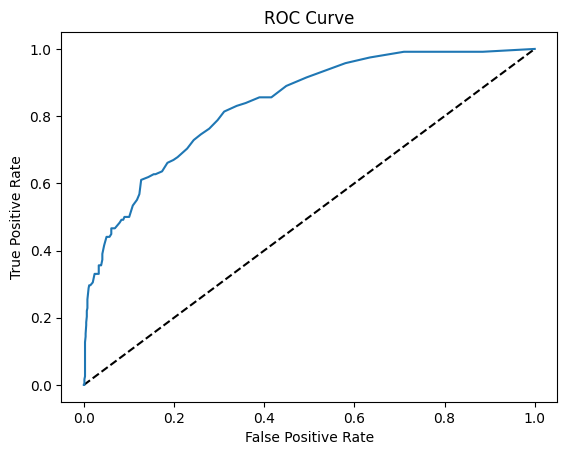

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid_filled, pred[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# K分割交差検証
from sklearn.model_selection import StratifiedKFold, cross_val_score
stratifiedkfold = StratifiedKFold(n_splits=10)  #K=10分割
scores = cross_val_score(rf_model, X_filled, y_filled, cv=stratifiedkfold, scoring='roc_auc')
print('Cross-Validation scores: {}'.format(scores))   # 各分割におけるスコア
print('Average score: {}'.format(np.mean(scores)))  # スコアの平均値

Cross-Validation scores: [0.86712375 0.86113712 0.8306689  0.84474916 0.87197324 0.79541806
 0.82220736 0.75846939 0.72098639 0.74104157]
Average score: 0.8113774941414691


## LightGBM
- 欠損値について
  - 参考文献(https://nigimitama.hatenablog.jp/entry/2020/09/28/000000) より、むしろそのままの方が精度が高い可能性
- モデル構築について
  - 参考文献
    - https://qiita.com/c60evaporator/items/351188110f328ff921b9 （パラメータチューニングに関して）
    - https://qiita.com/d_desuyon/items/807e01311ad08570ee78 （２値分類に関して）

In [ ]:
y = df_train["ProdTaken"]
X = df_train.drop(columns =['id','ChildrenStatus','NumberOfPersonVisiting','NumberOfFollowups','PreferredPropertyStar','Occupation_Small Business','PitchSatisfactionScore','ProdTaken'], axis = 1)
X.head()

,Age,CityTier,DurationOfPitch,Gender,NumberOfTrips,Passport,MonthlyIncome,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,CarStatus,MarriageStatus_married,MarriageStatus_unmarried
0,50.0,2,15.0,1,5.0,1,253905.0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,56.0,1,14.0,1,2.0,1,404475.0,0,0,1,0,0,1,0,0,1,0,1,0,0
2,NaN,1,10.0,0,4.0,0,278145.0,1,0,0,0,1,0,0,0,0,0,0,1,0
3,37.0,2,18.0,0,1.0,0,326805.0,0,0,1,0,1,0,0,0,1,0,1,0,0
4,48.0,3,17.0,0,4.0,0,258435.0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# cv（クロスバリデーション用）とeval（early_stopping評価用）に分割
X_cv, X_eval, y_cv, y_eval = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from lightgbm import LGBMClassifier # Scikit-learn API
from sklearn.model_selection import KFold

In [ ]:
# パラメータチューニング前のモデル構築
# 使用するチューニング対象外のパラメータ
params = {
    'objective': 'binary',  # ２値分類
    'metric': 'auc',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
    'random_state': 42,  # 乱数シード
    'boosting_type': 'gbdt',
    'n_estimators': 10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
    'verbose': -1,  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
    'early_stopping_round': 10  # ここでearly_stoppingを指定
    }
# モデル作成
lgbm_model = LGBMClassifier(**params)
# 学習時fitパラメータ指定
fit_params = {
    'eval_set': [(X_eval, y_eval)]  # early_stopping用のデータeval_setを渡す
    }


In [ ]:
scoring = 'roc_auc'  # 評価指標をAUCに指定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# クロスバリデーションで評価指標算出
scores = cross_val_score(lgbm_model, X_cv, y_cv, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')

scores=[0.79454006 0.80455964 0.77762569 0.82200047 0.80641369]
average_score=0.8010279103274126


In [ ]:
# from sklearn.model_selection import validation_curve
# import matplotlib.pyplot as plt
# cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
#              'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
#              'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
#              'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#              'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#              'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
#              'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#              }
# param_scales = {'reg_alpha': 'log',
#                 'reg_lambda': 'log',
#                 'num_leaves': 'linear',
#                 'colsample_bytree': 'linear',
#                 'subsample': 'linear',
#                 'subsample_freq': 'linear',
#                 'min_child_samples': 'linear'
#                 }
# # 検証曲線のプロット（パラメータ毎にプロット）
# for i, (k, v) in enumerate(cv_params.items()):
#     train_scores, valid_scores = validation_curve(estimator=lgbm_model,
#                                                   X=X_cv, y=y_cv,
#                                                   param_name=k,
#                                                   param_range=v,
#                                                   fit_params=fit_params,
#                                                   cv=cv, scoring=scoring,
#                                                   n_jobs=-1)
#     # 学習データに対するスコアの平均±標準偏差を算出
#     train_mean = np.mean(train_scores, axis=1)
#     train_std  = np.std(train_scores, axis=1)
#     train_center = train_mean
#     train_high = train_mean + train_std
#     train_low = train_mean - train_std
#     # テストデータに対するスコアの平均±標準偏差を算出
#     valid_mean = np.mean(valid_scores, axis=1)
#     valid_std  = np.std(valid_scores, axis=1)
#     valid_center = valid_mean
#     valid_high = valid_mean + valid_std
#     valid_low = valid_mean - valid_std
#     # training_scoresをプロット
#     plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
#     plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
#     # validation_scoresをプロット
#     plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
#     plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
#     # スケールをparam_scalesに合わせて変更
#     plt.xscale(param_scales[k])
#     # 軸ラベルおよび凡例の指定
#     plt.xlabel(k)  # パラメータ名を横軸ラベルに
#     plt.ylabel(scoring)  # スコア名を縦軸ラベルに
#     plt.legend(loc='lower right')  # 凡例
#     # グラフを描画
#     plt.show()


In [ ]:
# from sklearn.model_selection import validation_curve
# import matplotlib.pyplot as plt
# lgbm_model.set_params(num_leaves=32)
# # 検証曲線のプロット（パラメータ毎にプロット）
# for i, (k, v) in enumerate(cv_params.items()):
#     train_scores, valid_scores = validation_curve(estimator=lgbm_model,
#                                                   X=X, y=y,
#                                                   param_name=k,
#                                                   param_range=v,
#                                                   fit_params=fit_params,
#                                                   cv=cv, scoring=scoring,
#                                                   n_jobs=-1)
#     # 学習データに対するスコアの平均±標準偏差を算出
#     train_mean = np.mean(train_scores, axis=1)
#     train_std  = np.std(train_scores, axis=1)
#     train_center = train_mean
#     train_high = train_mean + train_std
#     train_low = train_mean - train_std
#     # テストデータに対するスコアの平均±標準偏差を算出
#     valid_mean = np.mean(valid_scores, axis=1)
#     valid_std  = np.std(valid_scores, axis=1)
#     valid_center = valid_mean
#     valid_high = valid_mean + valid_std
#     valid_low = valid_mean - valid_std
#     # training_scoresをプロット
#     plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
#     plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
#     # validation_scoresをプロット
#     plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
#     plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
#     # スケールを'log'に（線形なパラメータは'linear'にするので注意）
#     plt.xscale(param_scales[k])
#     # 軸ラベルおよび凡例の指定
#     plt.xlabel(k)  # パラメータ名を横軸ラベルに
#     plt.ylabel(scoring)  # スコア名を縦軸ラベルに
#     plt.legend(loc='lower right')  # 凡例
#     # グラフを描画
#     plt.show()


In [ ]:
# Optunaによるベイズ最適化を用いたパラメータ選択
!pip install optuna
import optuna

# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 10, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 100)
    }
    # モデルにパラメータ適用
    lgbm_model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(lgbm_model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


[I 2024-09-01 12:01:58,182] A new study created in memory with name: no-name-4c0318ff-ad36-44b8-9d2f-9f62ca12c077
[I 2024-09-01 12:01:59,507] Trial 0 finished with value: 0.8082281383581378 and parameters: {'reg_alpha': 0.0074593432857265485, 'reg_lambda': 5.669849511478847, 'num_leaves': 94, 'colsample_bytree': 0.759195090518222, 'subsample': 0.4936111842654619, 'subsample_freq': 1, 'min_child_samples': 5}. Best is trial 0 with value: 0.8082281383581378.
[I 2024-09-01 12:02:00,190] Trial 1 finished with value: 0.8127098898939649 and parameters: {'reg_alpha': 2.1423021757741068, 'reg_lambda': 0.10129197956845731, 'num_leaves': 91, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'subsample_freq': 6, 'min_child_samples': 21}. Best is trial 1 with value: 0.8127098898939649.
[I 2024-09-01 12:02:00,755] Trial 2 finished with value: 0.8043941562457931 and parameters: {'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0008260808399079611, 'num_leaves': 40, 'colsamp

最適パラメータ {'reg_alpha': 5.39506229447308, 'reg_lambda': 0.013000766295691529, 'num_leaves': 55, 'colsample_bytree': 0.45981146221094826, 'subsample': 0.4410953537517899, 'subsample_freq': 3, 'min_child_samples': 70}
スコア 0.8402208947448477


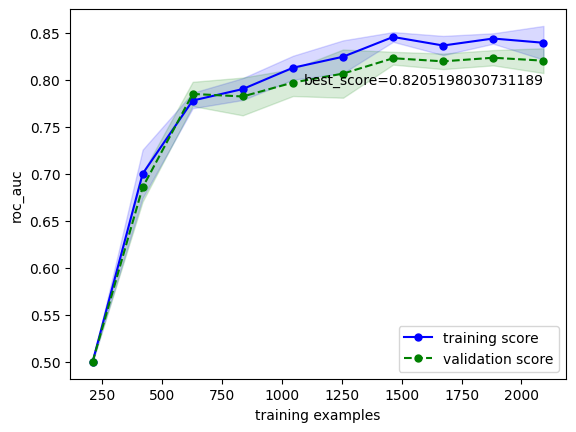

In [ ]:
# 最適パラメータにおける過学習の確認

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
lgbm_model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=lgbm_model,
                                                         X=X_cv, y=y_cv,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=cv, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例


In [ ]:
# クロスバリデーションで評価指標算出
scores = cross_val_score(lgbm_model, X_cv, y_cv, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')

scores=[0.80410009 0.82900624 0.80678206 0.83642411 0.83520833]
average_score=0.8223041675076954


In [ ]:
from sklearn.model_selection import train_test_split

# トレーニングデータをトレーニング用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルのトレーニング（early stopping の設定）
lgbm_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],  # 検証用データセットを指定
    eval_metric='roc_auc',      # 評価指標を指定（ここでは logloss を使用）
)


LGBMClassifier(colsample_bytree=0.45981146221094826, early_stopping_round=10,
               metric='auc', min_child_samples=70, n_estimators=10000,
               num_leaves=55, objective='binary', random_state=42,
               reg_alpha=5.39506229447308, reg_lambda=0.013000766295691529,
               subsample=0.4410953537517899, subsample_freq=3, verbose=-1)

[[-0.11850014  0.24919157 -0.01701499 ...  0.06155866  0.03621089
   0.30486712]
 [-0.0645915  -0.27423596 -0.01616498 ... -0.04219285  0.0122986
  -0.06823663]
 [ 0.52647567 -0.28137702 -0.0132647  ...  0.07222089 -0.03657801
  -0.17283513]
 ...
 [-0.00188428 -0.26545968 -0.03841646 ... -0.06565577  0.01469686
   0.15857419]
 [-0.0584986   0.13037139 -0.04276791 ...  0.03869051 -0.01891028
  -0.08933903]
 [-0.19555636 -0.28958107 -0.08924309 ...  0.06709882 -0.07046025
  -0.18538436]]        Age  CityTier  DurationOfPitch  Gender  NumberOfTrips  Passport  \
0     50.0         2             15.0       1            5.0         1   
1     56.0         1             14.0       1            2.0         1   
2      NaN         1             10.0       0            4.0         0   
3     37.0         2             18.0       0            1.0         0   
4     48.0         3             17.0       0            4.0         0   
...    ...       ...              ...     ...            ...     

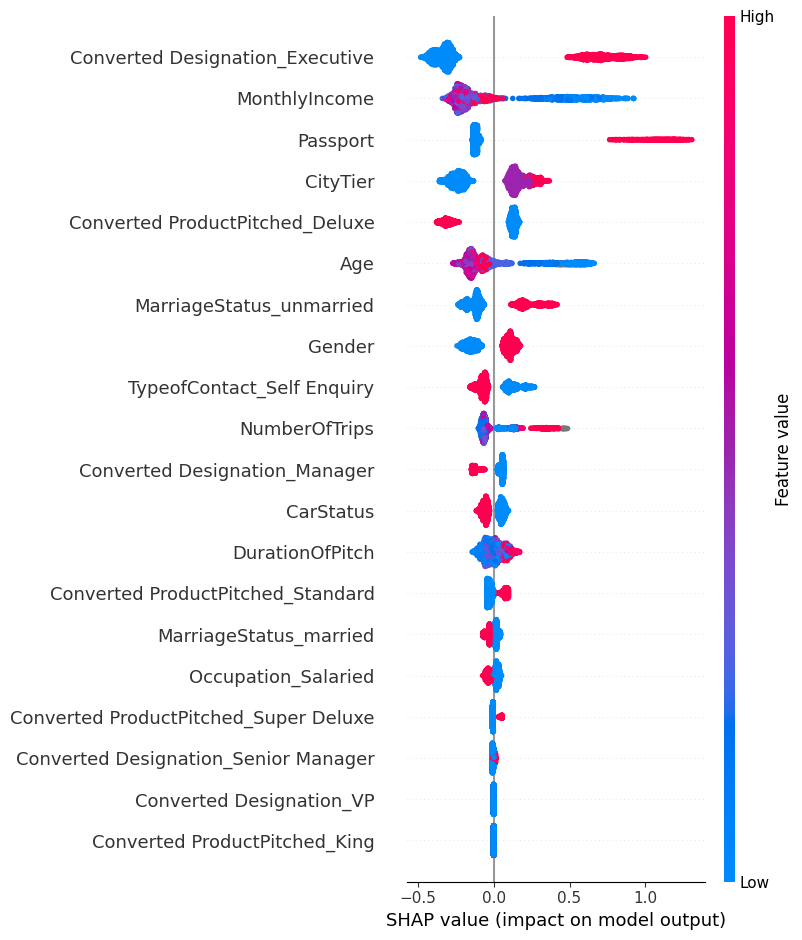

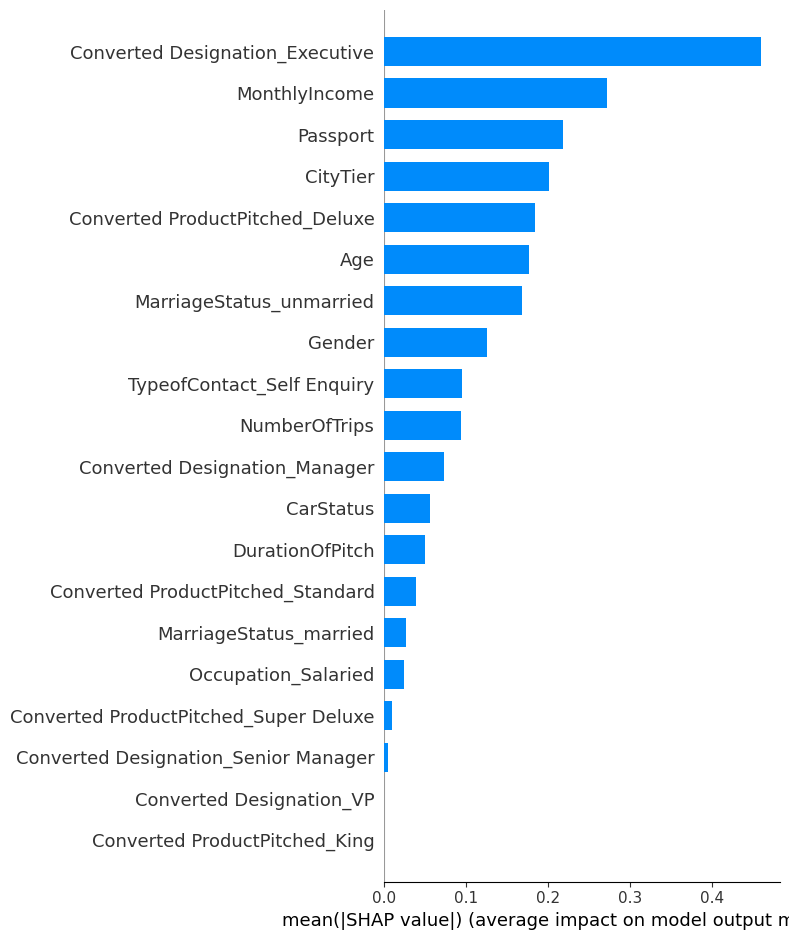

In [ ]:
# SHAPで特徴量の貢献度を把握する
!pip install shap
import shap
shap.initjs()

"""
shap.TreeExplainer:決定木用(XGBoost、lightBGM等含む)
shap.LinearExplainer :線形モデル用
shap.DeepExplainer :Deeplearning用
"""
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
# lgbm_model.fit(X, y, fit_params=fit_params)
explainer = shap.TreeExplainer(model=lgbm_model)
shap_values = explainer.shap_values(X=X)
print(shap_values, X)
shap.summary_plot(shap_values, X) #左側の図
shap.summary_plot(shap_values, X, plot_type='bar') #右側の図

# 提出

In [ ]:
# 提出用ファイル
test = df_test.drop(columns =['id','ChildrenStatus','NumberOfPersonVisiting','NumberOfFollowups','PreferredPropertyStar','Occupation_Small Business','PitchSatisfactionScore'], axis = 1)
test.head()

,Age,CityTier,DurationOfPitch,Gender,NumberOfTrips,Passport,MonthlyIncome,Converted Designation_Executive,Converted Designation_Manager,Converted Designation_Senior Manager,Converted Designation_VP,TypeofContact_Self Enquiry,Occupation_Salaried,Converted ProductPitched_Deluxe,Converted ProductPitched_King,Converted ProductPitched_Standard,Converted ProductPitched_Super Deluxe,CarStatus,MarriageStatus_married,MarriageStatus_unmarried
0,48.0,2,13.0,1,7.0,0,496950.0,0,0,0,0,1,0,0,0,0,1,1,1,0
1,30.0,2,12.0,0,4.0,1,300000.0,0,0,1,0,1,0,0,0,1,0,0,1,0
2,25.0,1,9.0,0,1.0,0,260000.0,1,0,0,0,1,1,0,0,0,0,0,0,0
3,21.0,2,7.0,1,1.0,0,259875.0,0,0,1,0,0,1,0,0,0,0,1,0,0
4,41.0,1,7.0,1,1.0,0,268830.0,1,0,0,0,0,1,0,0,0,0,1,0,1


In [ ]:
predict = lgbm_model.predict_proba(test)
print(predict[:5])

[[0.91583811 0.08416189]
 [0.69540542 0.30459458]
 [0.77049613 0.22950387]
 [0.70597699 0.29402301]
 [0.74282512 0.25717488]]


In [ ]:
# submit_sample.csvを読み込みます。
sample_sub.head()

,0,1
0,3489,0.084162
1,3490,0.304595
2,3491,0.229504
3,3492,0.294023
4,3493,0.257175


In [ ]:
# 提出ファイルの2列目を予測値で置き換えます。
sample_sub[1] = predict[:, 1]
sample_sub.head()

,0,1
0,3489,0.084162
1,3490,0.304595
2,3491,0.229504
3,3492,0.294023
4,3493,0.257175


In [ ]:
sample_sub.to_csv("submission_240901_03.csv", index=False, header=None)
from google.colab import files
files.download('submission_240901_03.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>